In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
import optuna
import statsmodels.api as sm

In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_alignment_features(resume_text, jd_text, transcript_text):
    features = {}

    # Embedding-based similarity
    resume_embedding = model.encode([resume_text])[0]
    jd_embedding = model.encode([jd_text])[0]
    transcript_embedding = model.encode([transcript_text])[0]

    features['resume_jd_similarity'] = cosine_similarity([resume_embedding], [jd_embedding])[0][0]
    features['transcript_jd_similarity'] = cosine_similarity([transcript_embedding], [jd_embedding])[0][0]

    return features


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
data = pd.read_excel('/content/drive/MyDrive/final_data.xlsx')

In [99]:
# Sentiment analysis using TestBlob library

In [5]:
from textblob import TextBlob

def analyze_sentiment(text):
    # Create a TextBlob object
    blob = TextBlob(text)

    # Get the sentiment polarity
    polarity = blob.sentiment.polarity

    return polarity

In [6]:
data['Transcript_sentiment'] = data['Transcript_processed'].apply(analyze_sentiment)
data['Resume_sentiment'] = data['Resume_processed'].apply(analyze_sentiment)
data['JobDescription_sentiment'] = data['Job_Description_processed'].apply(analyze_sentiment)

In [100]:
# Word count feature

In [7]:
def word_counts(text):
    return len(text.split())

In [8]:
data['Transcript_words'] = data['Transcript_processed'].apply(word_counts)
data['Resume_words'] = data['Resume_processed'].apply(word_counts)

In [101]:
# Extracting years of experience

In [9]:
import re
from datetime import datetime

def extract_years_of_experience(text):
    # Regular expression to extract years and date ranges
    date_ranges = re.findall(r"(\d{4})-(present|\d{4})", text.lower())

    total_years = 0
    current_year = datetime.now().year

    for start, end in date_ranges:
        start_year = int(start)
        end_year = current_year if end == "present" else int(end)

        total_years += (end_year - start_year)

    return total_years
data['Years_Experience']=data['Resume'].apply(extract_years_of_experience)

In [103]:
# Function for calculating Tf-Idf vectorizer embeddings and then similarity

In [10]:
def compute_tfidf_cosine_similarity(data, col1, col2):
    """
    Computes cosine similarity between resumes and job descriptions using TF-IDF.

    Parameters:
    - data (pd.DataFrame): Dataset containing resumes and job descriptions.
    - resume_col (str): Column name for resumes.
    - jd_col (str): Column name for job descriptions.

    Returns:
    - similarities (list): List of cosine similarity scores for each resume-JD pair.
    """
    similarities = []
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    for _, row in data.iterrows():
        resume_text = row[col1]
        jd_text = row[col2]

        # Combine texts for consistent vectorization
        texts = [resume_text, jd_text]
        tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

        # Convert sparse matrix to dense
        tfidf_dense = tfidf_matrix.toarray()

        # Padding vectors (if needed for consistency)
        max_length = max(len(vector) for vector in tfidf_dense)
        padded_vectors = np.array([np.pad(vector, (0, max_length - len(vector))) for vector in tfidf_dense])

        # Compute cosine similarity
        similarity = cosine_similarity(padded_vectors[0].reshape(1, -1), padded_vectors[1].reshape(1, -1))
        similarities.append(similarity[0][0])

    return similarities

In [11]:
data['resume_jd_similarity'] = compute_tfidf_cosine_similarity(data , 'Resume_processed' , 'Job_Description_processed')

In [12]:
data['Transcript_jd_similarity'] = compute_tfidf_cosine_similarity(data , 'Transcript_processed' , 'Job_Description_processed')

In [13]:
data['resume_transcript_similarity'] = compute_tfidf_cosine_similarity(data , 'Resume_processed' , 'Transcript_processed')

In [14]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [104]:
## Finding Resume and Job description based features like , skill match count and no.of education degrees from b.tech on wards , etc..

In [16]:
def extract_resume_features(resume_text, jd_text):
    features = {}

    # Length-based features
    features['resume_sentence_count'] = len(sent_tokenize(resume_text))
    features['resume_avg_word_length'] = sum(len(word) for word in word_tokenize(resume_text)) / len(word_tokenize(resume_text))

    # Skill match features
    jd_skills = set(re.findall(r'\b[A-Za-z]+\b', jd_text.lower()))
    resume_skills = set(re.findall(r'\b[A-Za-z]+\b', resume_text.lower()))
    features['skill_match_count'] = len(jd_skills & resume_skills)

    # Education features
    degrees = ['b.tech', 'm.tech', 'mba', 'phd', 'bachelor', 'master']
    features['university_education_count'] = sum(1 for degree in degrees if degree in resume_text.lower())

    return features


In [62]:
def process_dataset(data, resume_col, jd_col):
    """
    Process a dataset to extract features for each resume-JD pair.

    Parameters:
    - data (pd.DataFrame): Dataset containing resumes and job descriptions.
    - resume_col (str): Column name for resumes.
    - jd_col (str): Column name for job descriptions.

    Returns:
    - pd.DataFrame: Original dataset with extracted features appended.
    """
    extracted_features = []

    for _, row in data.iterrows():
        resume_text = row[resume_col]
        jd_text = row[jd_col]
        features = extract_resume_features(resume_text, jd_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_dataset(data, "Resume_processed", "Job_Description_processed")


In [18]:
processed_data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Role', 'Transcript', 'Resume', 'decision',
       'Reason for decision', 'Job Description', 'Transcript_processed',
       'Resume_processed', 'Job_Description_processed', 'Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count'],
      dtype='object')

In [105]:
## Extracting the features from transcript like vocabulary diversity , avg_sentence_length

In [19]:
def extract_transcript_features(transcript_text):
    features = {}
    # Language features
    features['transcript_vocab_diversity'] = len(set(word_tokenize(transcript_text))) / len(word_tokenize(transcript_text))
    features['transcript_avg_sentence_length'] = sum(len(sent.split()) for sent in sent_tokenize(transcript_text)) / len(sent_tokenize(transcript_text))
    return features


In [63]:
def process_transcript(data, transcript_col = 'Transcript_processed'):
    extracted_features = []

    for _, row in data.iterrows():
        transcript_text = row[transcript_col]
        features = extract_transcript_features(transcript_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_transcript(processed_data)


In [21]:
processed_data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Role', 'Transcript', 'Resume', 'decision',
       'Reason for decision', 'Job Description', 'Transcript_processed',
       'Resume_processed', 'Job_Description_processed', 'Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length'],
      dtype='object')

In [22]:
processed_data.to_excel('final_data_features.xlsx')

# ***Building Complete models using Tf-Idf embeddings similarity:***

In [107]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [108]:
req_data = processed_data[['Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'decision']]

In [109]:
req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)

In [110]:
req_data.head()

Transcript_sentiment  Resume_sentiment  JobDescription_sentiment  \
0              0.270412          0.307407                      0.50   
1              0.296350          0.130833                      0.50   
2              0.173791          0.202970                      0.50   
3              0.198376          0.131515                      0.50   
4              0.324771          0.111750                      0.25   

   Transcript_words  Resume_words  Years_Experience  resume_jd_similarity  \
0               348           221                14              0.268642   
1               387           241                11              0.238920   
2               282           255                14              0.375988   
3               402           237                 7              0.248950   
4               306           299                 0              0.307717   

   Transcript_jd_similarity  resume_transcript_similarity  \
0                  0.203080                      0.226753   
1                  0.098115                      0.169317   
2                  0.155779                      0.346429   
3                  0.175580                      0.235884   
4                  0.113163                      0.180783   

   resume_sentence_count  resume_avg_word_length  skill_match_count  \
0                      1                7.737557                  8   
1                      1                7.676349                  7   
2                      1                7.117647                  9   
3                      1                7.130802                  7   
4                      1                7.394649                  9   

   university_education_count  transcript_vocab_diversity  \
0                           2                    0.548851   
1                           2                    0.591731   
2                           1                    0.475177   
3                           1                    0.519900   
4                           2                    0.522876   

   transcript_avg_sentence_length decision  decision_processed  
0                           348.0   select                   1  
1                           387.0   select                   1  
2                           282.0   reject                   0  
3                           402.0   select                   1  
4                           306.0   reject                   0

1. Splitting the data for training and testing  

In [111]:
x , y = req_data.drop(columns = ['decision' , 'decision_processed']) , req_data['decision_processed']

In [112]:
train_x , test_x , train_y , test_y = train_test_split(x,y,train_size = 0.8 , random_state = 42)

In [113]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 2915 to 860
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Transcript_sentiment            2366 non-null   float64
 1   Resume_sentiment                2366 non-null   float64
 2   JobDescription_sentiment        2366 non-null   float64
 3   Transcript_words                2366 non-null   int64  
 4   Resume_words                    2366 non-null   int64  
 5   Years_Experience                2366 non-null   int64  
 6   resume_jd_similarity            2366 non-null   float64
 7   Transcript_jd_similarity        2366 non-null   float64
 8   resume_transcript_similarity    2366 non-null   float64
 9   resume_sentence_count           2366 non-null   int64  
 10  resume_avg_word_length          2366 non-null   float64
 11  skill_match_count               2366 non-null   int64  
 12  university_education_count      2366 

In [114]:
train_y.head()

2915    1
573     0
1553    0
1877    0
2954    0
Name: decision_processed, dtype: int64

In [33]:
# pip install optuna

In [115]:
## Optuna is used for hyper parameter tuning

In [116]:
## Addding the minor noise in order to eliminate perfect correlation for logistic regression implementation in statsmodels library
train_x += np.random.normal(0, 1e-4, train_x.shape)
test_x += np.random.normal(0, 1e-4, test_x.shape)

Logistic regression model building and analysis

In [117]:

# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x, train_y)
X_test_const = sm.add_constant(test_x)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_logistic))
print("Precision:", precision_score(test_y, y_pred_logistic))
print("Recall:", recall_score(test_y, y_pred_logistic))
print("F1 Score:", f1_score(test_y, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y, y_pred_logistic))


         Current function value: 0.470977
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     decision_processed   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           15
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                  0.3202
Time:                        04:01:26   Log-Likelihood:                -1114.3
converged:                      False   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                3.002e-214
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -146.8939    513.908     -0.286      0.775   -1154.135     860.347
Trans

1. from this model it came to know that Transcript words , resume_job desc similarity are not much useful
2. resume transcript similarity , transcript avg sentence length , resume sent count , university count , resume avg words are also not uyseful

This might be due to Tf-idf transformer


In [118]:
# model without those cols ,
x1 , y1 = req_data.drop(columns = ['decision' , 'decision_processed' , 'Transcript_words' , 'resume_jd_similarity' , 'resume_transcript_similarity' , 'resume_sentence_count' , 'university_education_count' , 'resume_avg_word_length' , 'transcript_avg_sentence_length' , 'Resume_words' , 'Years_Experience']) , req_data['decision_processed']

In [119]:
train_x1 , test_x1 , train_y1 , test_y1 = train_test_split(x1,y1,train_size = 0.8 , random_state = 42)

In [120]:

# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x1, train_y1)
X_test_const = sm.add_constant(test_x1)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y1, y_pred_logistic))
print("Precision:", precision_score(test_y1, y_pred_logistic))
print("Recall:", recall_score(test_y1, y_pred_logistic))
print("F1 Score:", f1_score(test_y1, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y1, y_pred_logistic))


Optimization terminated successfully.
         Current function value: 0.591976
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     decision_processed   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2359
Method:                           MLE   Df Model:                            6
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                  0.1455
Time:                        04:03:12   Log-Likelihood:                -1400.6
converged:                       True   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                7.126e-100
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.3295      0.532     -8.139      0.000      

In [77]:

# XGBoost with Optuna for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    return accuracy_score(test_y, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Train XGBoost with best parameters
best_params = study.best_params
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(train_x, train_y)
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

[I 2025-01-06 03:28:49,859] A new study created in memory with name: no-name-deeb84f4-0af9-45a0-a56b-ae4cf04d0709
[I 2025-01-06 03:28:50,142] Trial 0 finished with value: 0.7837837837837838 and parameters: {'n_estimators': 647, 'max_depth': 8, 'learning_rate': 0.23329824929145643, 'subsample': 0.7151370437862158, 'colsample_bytree': 0.7830152210923087, 'gamma': 3.5064627773961474, 'min_child_weight': 10}. Best is trial 0 with value: 0.7837837837837838.
[I 2025-01-06 03:28:50,597] Trial 1 finished with value: 0.7888513513513513 and parameters: {'n_estimators': 652, 'max_depth': 7, 'learning_rate': 0.02061370106030519, 'subsample': 0.6426814850652633, 'colsample_bytree': 0.6243675399418034, 'gamma': 3.743039339878388, 'min_child_weight': 7}. Best is trial 1 with value: 0.7888513513513513.
[I 2025-01-06 03:28:50,756] Trial 2 finished with value: 0.7888513513513513 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.1268640564807549, 'subsample': 0.5899162641691343, 'c

Best parameters: {'n_estimators': 703, 'max_depth': 10, 'learning_rate': 0.26086365325727257, 'subsample': 0.8827063638221199, 'colsample_bytree': 0.7548035241955746, 'gamma': 1.3322188519901066, 'min_child_weight': 2}
XGBoost Metrics:
Accuracy: 0.8158783783783784
Precision: 0.79
Recall: 0.8374558303886925
F1 Score: 0.8130360205831904


<Figure size 1000x800 with 0 Axes>

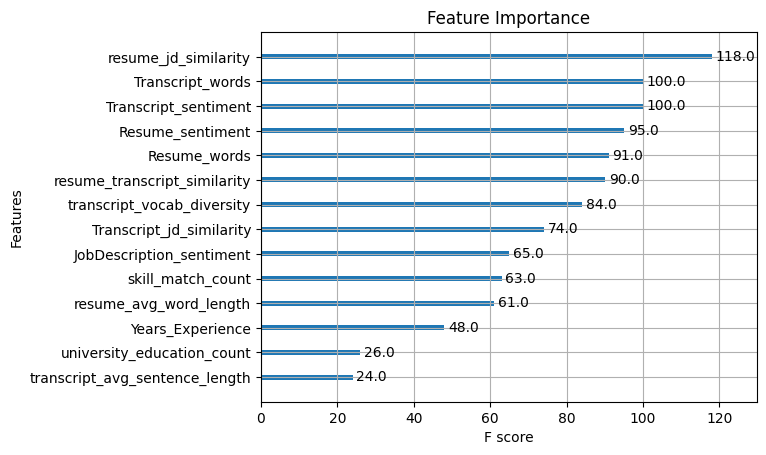

In [79]:
## Plotting the feature importance for Xgboost model
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', title='Feature Importance')
plt.show()

In [85]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train and evaluate Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_x, train_y)  # Fit the model
y_pred_nb = nb_model.predict(test_x)  # Predict on test set

# Evaluation
print("Naive Bayes Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_nb))
print("Precision:", precision_score(test_y, y_pred_nb))
print("Recall:", recall_score(test_y, y_pred_nb))
print("F1 Score:", f1_score(test_y, y_pred_nb))


Naive Bayes Metrics (TF-IDF):
Accuracy: 0.7297297297297297
Precision: 0.7573221757322176
Recall: 0.6395759717314488
F1 Score: 0.6934865900383141


In [97]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_x, train_y)  # Fit the model
y_pred_rf = rf_model.predict(test_x)  # Predict on test set

# Evaluation
print("Random Forest Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_rf))
print("Precision:", precision_score(test_y, y_pred_rf))
print("Recall:", recall_score(test_y, y_pred_rf))
print("F1 Score:", f1_score(test_y, y_pred_rf))

Random Forest Metrics (TF-IDF):
Accuracy: 0.7972972972972973
Precision: 0.7879858657243817
Recall: 0.7879858657243817
F1 Score: 0.7879858657243817


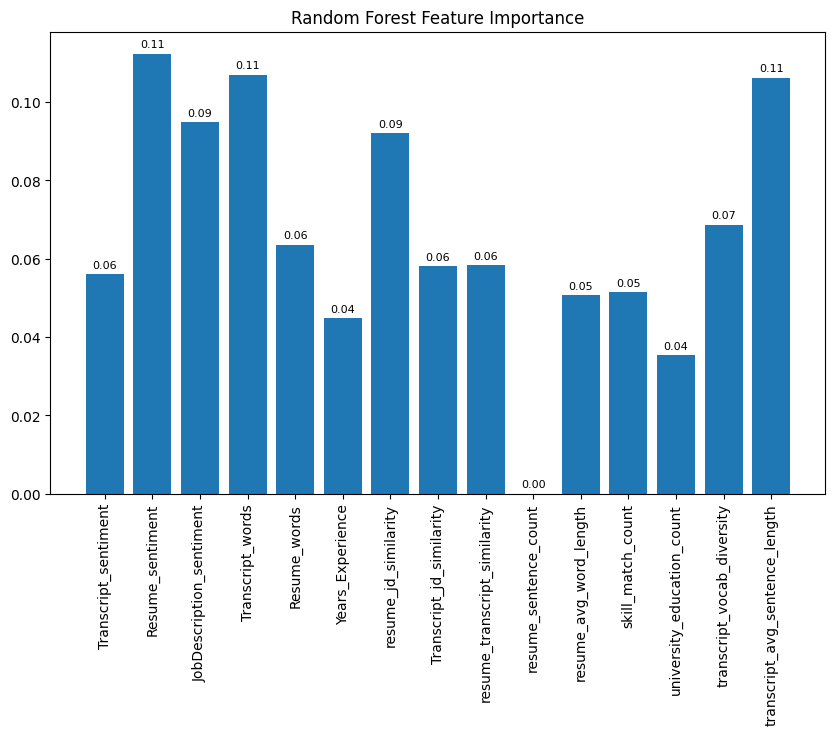

In [98]:
# Add values on top of the bars
plt.figure(figsize=(10, 6))
plt.bar(train_x.columns, importance)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")

# Annotate each bar with its value
for i, v in enumerate(importance):
    plt.text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

plt.show()

In [87]:
from sklearn.svm import SVC

# Train and evaluate SVC
svc_model = SVC(kernel="linear", random_state=42)
svc_model.fit(train_x, train_y)  # Fit the model
y_pred_svc = svc_model.predict(test_x)  # Predict on test set

# Evaluation
print("SVC Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_svc))
print("Precision:", precision_score(test_y, y_pred_svc))
print("Recall:", recall_score(test_y, y_pred_svc))
print("F1 Score:", f1_score(test_y, y_pred_svc))


SVC Metrics (TF-IDF):
Accuracy: 0.7787162162162162
Precision: 0.7835820895522388
Recall: 0.7420494699646644
F1 Score: 0.7622504537205081


# ***Computation of Similarity scores between resume , transcript , job description using Sentence Transformers Library***

In [64]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_alignment_features(resume_text, jd_text, transcript_text):
    features = {}

    # Embedding-based similarity
    resume_embedding = model.encode([resume_text])[0]
    jd_embedding = model.encode([jd_text])[0]
    transcript_embedding = model.encode([transcript_text])[0]

    features['resume_jd_similarity_transformers'] = cosine_similarity([resume_embedding], [jd_embedding])[0][0]
    features['transcript_jd_similarity_transformers'] = cosine_similarity([transcript_embedding], [jd_embedding])[0][0]
    features['transcript_resume_similarity_transformers'] = cosine_similarity([transcript_embedding], [resume_embedding])[0][0]

    return features

def process_transformer_similarity(data):
    extracted_features = []

    for _, row in data.iterrows():
        resume_text = row['Resume_processed']
        jd_text = row['Job_Description_processed']
        transcript_text = row['Transcript_processed']
        features = compute_alignment_features(resume_text, jd_text, transcript_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_transformer_similarity(processed_data)


In [65]:
processed_data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Role', 'Transcript', 'Resume', 'decision',
       'Reason for decision', 'Job Description', 'Transcript_processed',
       'Resume_processed', 'Job_Description_processed', 'Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length', 'resume_jd_similarity_transformers',
       'transcript_jd_similarity_transformers',
       'transcript_resume_similarity_transformers'],
      dtype='object')

In [137]:
req_data = processed_data[['Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity_transformers',
       'transcript_jd_similarity_transformers',
       'transcript_resume_similarity_transformers',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'decision']]
req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)
x , y = req_data.drop(columns = ['decision' , 'decision_processed']) , req_data['decision_processed']
train_x , test_x , train_y , test_y = train_test_split(x,y,train_size = 0.8 , random_state = 42)

In [138]:
train_x += np.random.normal(0, 1e-4, train_x.shape)
test_x += np.random.normal(0, 1e-4, test_x.shape)

# ***Building Complete models using sentence Transformer embeddings similarity:***

In [71]:
# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x, train_y)
X_test_const = sm.add_constant(test_x)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_logistic))
print("Precision:", precision_score(test_y, y_pred_logistic))
print("Recall:", recall_score(test_y, y_pred_logistic))
print("F1 Score:", f1_score(test_y, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y, y_pred_logistic))


         Current function value: 0.463452
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               decision   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           15
Date:                Mon, 06 Jan 2025   Pseudo R-squ.:                  0.3310
Time:                        03:15:35   Log-Likelihood:                -1096.5
converged:                      False   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                6.911e-222
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                       766.6227    528.930      1.449      0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


After using the Sentence transformers for finding similarity we got that
resume jd similarity and resume transcript similarity as useful features

In [140]:

# XGBoost with Optuna for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    return accuracy_score(test_y, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Train XGBoost with best parameters
best_params = study.best_params
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(train_x, train_y)
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

[I 2025-01-06 04:31:52,039] A new study created in memory with name: no-name-5f5d3bd0-0f3c-490e-8e96-36b0ee46e797
[I 2025-01-06 04:31:52,817] Trial 0 finished with value: 0.8141891891891891 and parameters: {'n_estimators': 971, 'max_depth': 10, 'learning_rate': 0.033977687542850646, 'subsample': 0.694306132365533, 'colsample_bytree': 0.5775822914903839, 'gamma': 1.6224200881176076, 'min_child_weight': 8}. Best is trial 0 with value: 0.8141891891891891.
[I 2025-01-06 04:31:53,239] Trial 1 finished with value: 0.8057432432432432 and parameters: {'n_estimators': 680, 'max_depth': 3, 'learning_rate': 0.0990701021580498, 'subsample': 0.7749029138589061, 'colsample_bytree': 0.8958404549414012, 'gamma': 1.8095709171600416, 'min_child_weight': 6}. Best is trial 0 with value: 0.8141891891891891.
[I 2025-01-06 04:31:53,712] Trial 2 finished with value: 0.8057432432432432 and parameters: {'n_estimators': 949, 'max_depth': 5, 'learning_rate': 0.12671283739628902, 'subsample': 0.6270143404429358, '

Best parameters: {'n_estimators': 423, 'max_depth': 8, 'learning_rate': 0.16547860476303514, 'subsample': 0.855306906030123, 'colsample_bytree': 0.7968544987982872, 'gamma': 3.2616079051925793, 'min_child_weight': 1}
XGBoost Metrics:
Accuracy: 0.8243243243243243
Precision: 0.8033898305084746
Recall: 0.8374558303886925
F1 Score: 0.8200692041522492


<Figure size 1000x800 with 0 Axes>

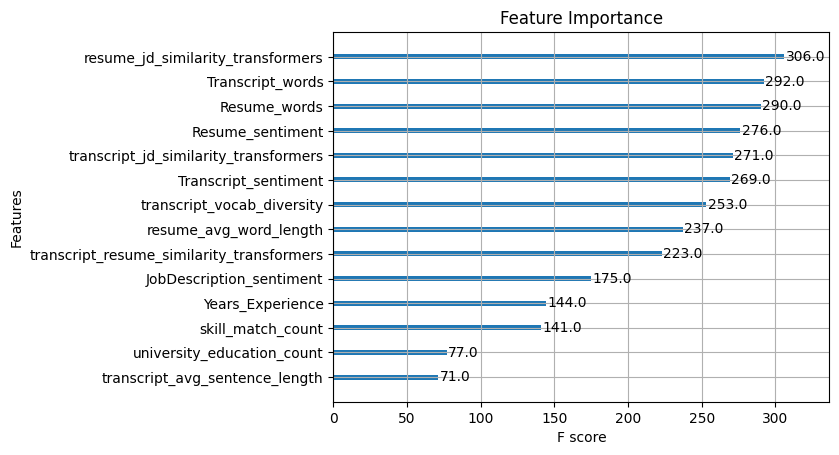

In [83]:
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', title='Feature Importance')
plt.show()

In [128]:
# Train and evaluate Naive Bayes
nb_model2 = GaussianNB()
nb_model2.fit(train_x, train_y)  # Fit the model
y_pred_nb = nb_model2.predict(test_x)  # Predict on test set

# Evaluation
print("Naive Bayes Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_nb))
print("Precision:", precision_score(test_y, y_pred_nb))
print("Recall:", recall_score(test_y, y_pred_nb))
print("F1 Score:", f1_score(test_y, y_pred_nb))


Naive Bayes Metrics (SentenceTransformer):
Accuracy: 0.7364864864864865
Precision: 0.7613168724279835
Recall: 0.6537102473498233
F1 Score: 0.7034220532319392


In [133]:
importance = 1 / np.sqrt(nb_model2.var_)
mean_importance = importance.mean(axis=0)  # Average across classes
print("Mean Feature Importance:", mean_importance)

Mean Feature Importance: [1.94884216e+01 1.25392787e+01 4.44761255e+00 1.26964475e-02
 2.38851666e-02 1.47528613e-01 5.38955471e+00 6.38916708e+00
 1.29497846e+01 3.73785530e+02 3.59450046e+00 4.38903803e-02
 1.11742838e+00 1.90994526e+01 1.26964477e-02]


In [124]:
# Train and evaluate Random Forest Classifier
rf_model2 = RandomForestClassifier(random_state=42)
rf_model2.fit(train_x, train_y)  # Fit the model
y_pred_rf = rf_model2.predict(test_x)  # Predict on test set

# Evaluation
print("Random Forest Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_rf))
print("Precision:", precision_score(test_y, y_pred_rf))
print("Recall:", recall_score(test_y, y_pred_rf))
print("F1 Score:", f1_score(test_y, y_pred_rf))


Random Forest Metrics (SentenceTransformer):
Accuracy: 0.8175675675675675
Precision: 0.8091872791519434
Recall: 0.8091872791519434
F1 Score: 0.8091872791519434


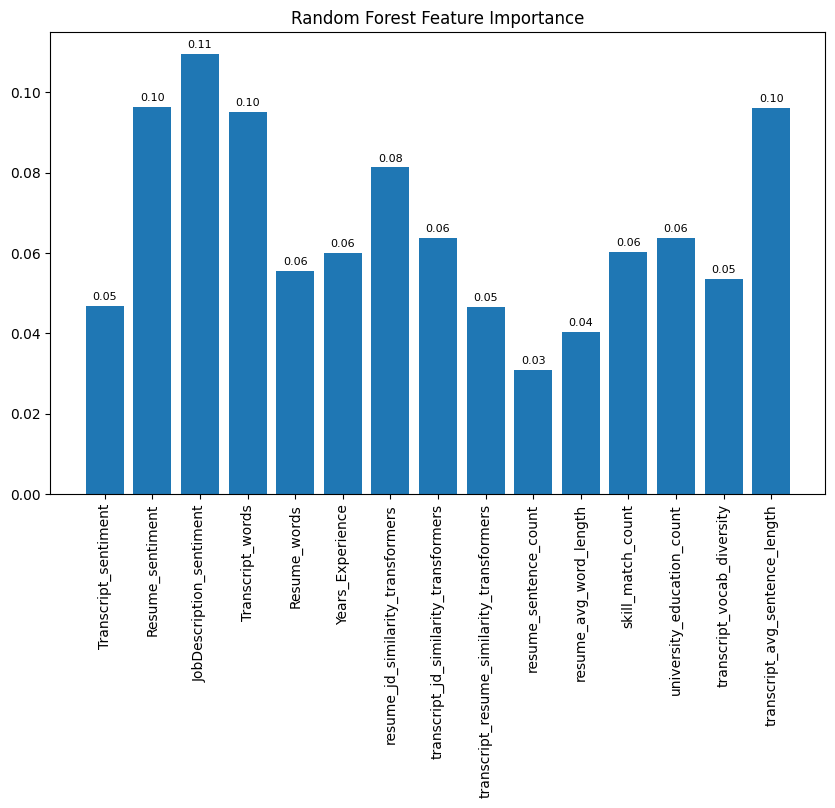

In [127]:
importance = rf_model2.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(x.columns, importance)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
for i, v in enumerate(importance):
    plt.text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

plt.show()


In [91]:
# Train and evaluate SVC
svc_model = SVC(kernel="linear", random_state=42)
svc_model.fit(train_x, train_y)  # Fit the model
y_pred_svc = svc_model.predict(test_x)  # Predict on test set

# Evaluation
print("SVC Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_svc))
print("Precision:", precision_score(test_y, y_pred_svc))
print("Recall:", recall_score(test_y, y_pred_svc))
print("F1 Score:", f1_score(test_y, y_pred_svc))


SVC Metrics (SentenceTransformer):
Accuracy: 0.793918918918919
Precision: 0.7970479704797048
Recall: 0.7632508833922261
F1 Score: 0.779783393501805


# ***In comparision to all the models, ***

# ***XGBOOST model is working well with the data as it is giving high accuracy , with sentence transformers ***

In [135]:
# so saving the best model

In [141]:
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

XGBoost Metrics:
Accuracy: 0.8243243243243243
Precision: 0.8033898305084746
Recall: 0.8374558303886925
F1 Score: 0.8200692041522492


In [ ]:
import xgboost as xgb

# Assuming `model` is your trained XGBoost model
model.save_model("model.bin")

# To load the model back
loaded_model = xgb.Booster()
loaded_model.load_model("model.bin")
